In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf


In [2]:
size = 256
batch_size = 128
epochs = 22
history = {}
def build_model(initializer):
    input_shape = (size, size, 3)
    hidden_layer_1 = 1024
    hidden_layer_2 = 512
    num_classes = 39
    layers = [
        Flatten(input_shape=input_shape),
        Dense(hidden_layer_1, activation='relu', kernel_initializer=initializer),
        Dense(hidden_layer_2, activation='relu', kernel_initializer=initializer),
        Dense(num_classes, activation='softmax', kernel_initializer=initializer)
    ]
    model = tf.keras.Sequential(layers)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False),
    metrics=['accuracy']
    )
    return model

In [3]:
#optim = {}
#sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
#optim['sgd'] = sgd
#sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
#optim['sgd_momentum'] = sgd_momentum
#rmsprop = tf.keras.optimizers.RMSprop(
    #learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07)
#optim['rmsprop'] = rmsprop
#adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#optim['adam'] = adam
#lr = [1., 0.1, 0.01, 1e-3, 1e-4]
initializer = tf.keras.initializers.GlorotNormal()

In [4]:
train_path = '../input/official-leaf/train_aug'
test_path = '../input/official-test/test'
gen = ImageDataGenerator(rescale=1./255)
train_generator = gen.flow_from_directory(train_path,     
    target_size = (size, size),
    shuffle=True, 
    batch_size=batch_size
)
valid_generator = gen.flow_from_directory(test_path,     
    target_size = (size, size),
    shuffle=False, 
    batch_size=batch_size
)

Found 53164 images belonging to 39 classes.
Found 11104 images belonging to 39 classes.


In [5]:
def train_model():
    model = build_model(initializer)
    model.summary()
    print('This is a SGD_momentum model using lr of: 0.001')
    print()
    model_save = ModelCheckpoint('./ANN_SGD_momentum_official_lr_0.001.h5',
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = 'val_loss', 
                                 mode = 'min', verbose = 1)

    milestones = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, reduce_lr, early_stop]
              )
    history['SGD_momentum_lr_0.001'] = milestones

In [6]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)
train_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              201327616 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 39)                20007     
Total params: 201,872,423
Trainable params: 201,872,423
Non-trainable params: 0
_________________________________________________________________
This is a SGD_momentum model using lr of: 0.001

Epoch 1/22
415/415 [==============================] - 661s 2s/step - loss: 2.7447 - accuracy: 0.2844 - val_loss: 1.6218 - val_accuracy: 0.5316

Epoch 00001: val_loss improved from inf to 1.62

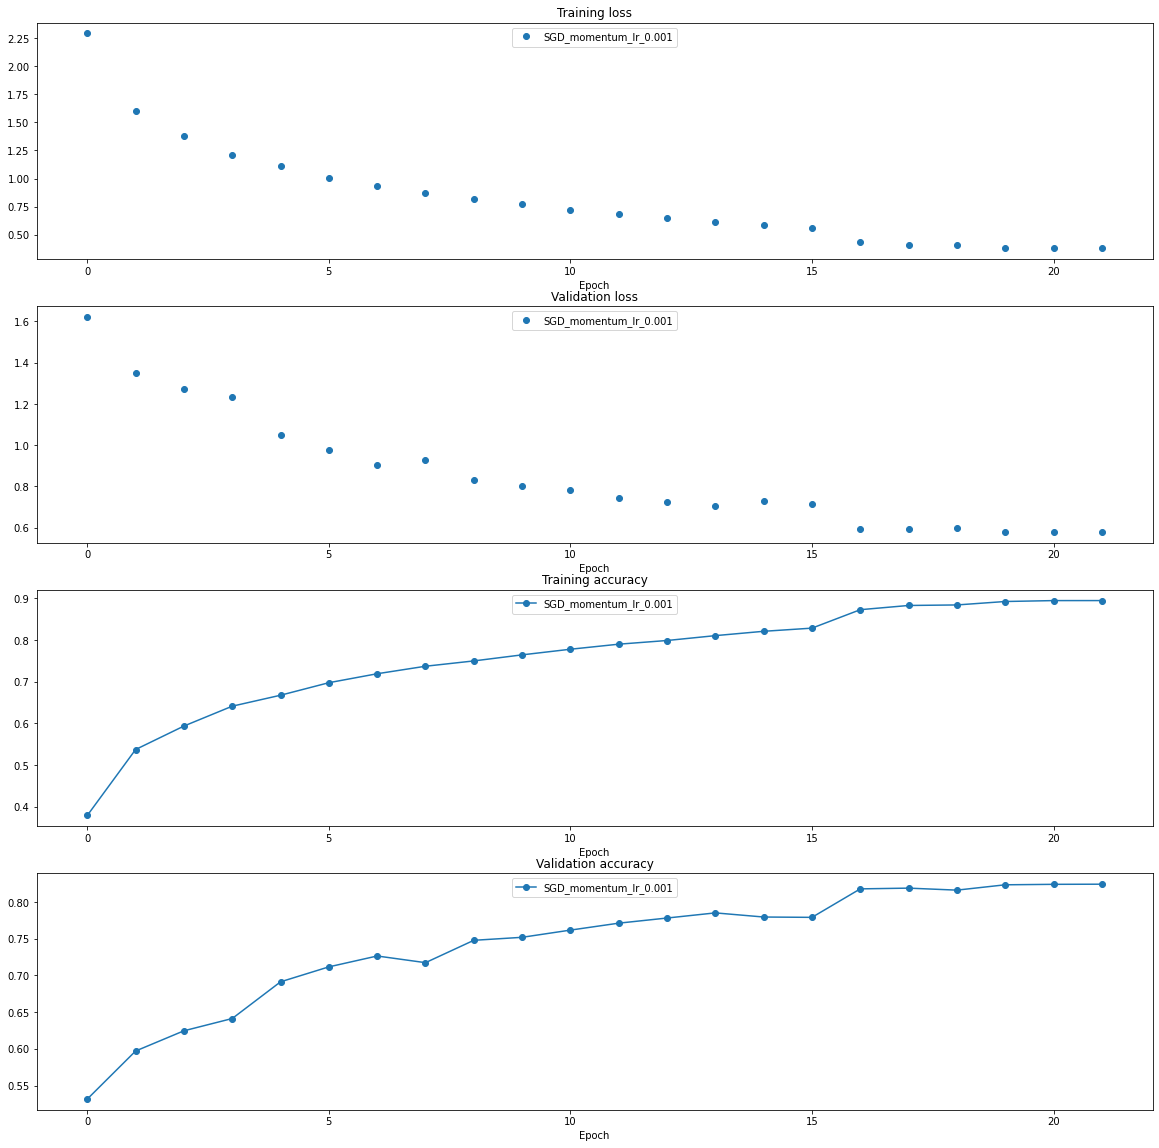

In [7]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()